In [4]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import gzip
import json
from matplotlib import pyplot as plt

def load_jsonlines_to_df(file_path):
    """
    Loads a gzipped JSON Lines file into a Pandas DataFrame,
    processes the 'accession_type' to ensure it's a single string label,
    balances the dataset by sampling up to 10000 instances per class,
    and selects only the specified columns.

    :param file_path: Path to the .jsonl.gz file.
    :return: A balanced Pandas DataFrame with selected columns and a LabelEncoder.
    """
    with gzip.open(file_path, 'rt', encoding='utf-8') as gzfile:
        data = [json.loads(line) for line in gzfile]
    
    columns_to_keep = ['abstract', 'accession_type']
    
    # Create DataFrame
    df = pd.DataFrame(data)
    df = df[columns_to_keep]
    
    # Ensure 'accession_type' exists
    if 'accession_type' not in df.columns:
        raise KeyError("Column 'accession_type' not found in the dataset.")
    
    # Process 'accession_type' to ensure it's a single string
    df['accession_type'] = df['accession_type'].apply(
        lambda labels: 'metagenomics' if 'metagenomics' in labels else 'other'
    )
    
    # Encode 'accession_type' into 'label'
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['accession_type'])
    
#     # Balance the dataset: sample up to 10000 instances per class
#     df_balanced = df.groupby('accession_type').apply(
#         lambda x: x.sample(n=min(500, len(x)), random_state=0)
#     ).reset_index(drop=True)

    df_balanced = df.copy()
    # Diagnostic Checks
    print(f"Loaded DataFrame shape: {df_balanced.shape}")
    print("Label distribution after balancing:")
    print(df_balanced['accession_type'].value_counts())
    print("\nSample data:")
    print(df_balanced.head())
    
    df_balanced.rename(columns={'accession_type': 'class_label'}, inplace=True)
    return df_balanced, label_encoder

# File paths
file_path = '/nfs/production/literature/santosh_tirunagari/BACKUP/work/github/metagenomics/notebooks/final_multi_label_trainingset.jsonl.gz'

data, label_encoder = load_jsonlines_to_df(file_path)
# Sample size
# n = 10000  # Set your desired sample size
# 
data
# 
# data

Loaded DataFrame shape: (219802, 3)
Label distribution after balancing:
accession_type
other           210302
metagenomics      9500
Name: count, dtype: int64

Sample data:
                                            abstract accession_type  label
0  Down-regulation of the Drosophila ribosomal pr...          other      1
1  Human chromosomal region 1q24 encodes two clon...          other      1
2  A bovine plasminogen activator was purified fr...          other      1
3  Staphylococcus aureus and Staphylococcus epide...          other      1
4  Kinetic analysis of two mutations within Pseud...          other      1


,abstract,class_label,label
0,Down-regulation of the Drosophila ribosomal pr...,other,1
1,Human chromosomal region 1q24 encodes two clon...,other,1
2,A bovine plasminogen activator was purified fr...,other,1
3,Staphylococcus aureus and Staphylococcus epide...,other,1
4,Kinetic analysis of two mutations within Pseud...,other,1
...,...,...,...
219797,Kaposi's sarcoma-associated herpesvirus (KSHV)...,other,1
219798,The pathway of autotrophic CO2 fixation was st...,other,1
219799,The mannose-sensitive hemagglutinin (MSHA) of ...,other,1
219800,Pseudomonas putida GJ31 contains an unusual ca...,other,1


In [5]:
import torch

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [6]:
import os
import pandas as pd

def load_abstracts_from_folders(folder_1_path, folder_2_path):
    """
    Loads abstracts from two folders into a pandas DataFrame.

    Parameters:
        folder_1_path (str): Path to the folder containing metagenomics abstracts.
        folder_2_path (str): Path to the folder containing other abstracts.

    Returns:
        pd.DataFrame: A DataFrame containing abstracts and their class labels.
    """
    abstracts = []
    class_labels = []

    # Load abstracts from folder_1 (metagenomics)
    for file_name in os.listdir(folder_1_path):
        file_path = os.path.join(folder_1_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8') as file:
                abstracts.append(file.read())
                class_labels.append('metagenomics')

    # Load abstracts from folder_2 (other)
    for file_name in os.listdir(folder_2_path):
        file_path = os.path.join(folder_2_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8') as file:
                abstracts.append(file.read())
                class_labels.append('other')

    # Create DataFrame
    data = pd.DataFrame({
        'abstract': abstracts,
        'class_label': class_labels
    })

    return data

# Paths to folders
folder_1_path = "/nfs/production/literature/santosh_tirunagari/mgnify_abstracts/txt/abs/"  # Update with the actual path to folder_1
folder_2_path = "/nfs/production/literature/santosh_tirunagari/txt/abs"  # Update with the actual path to folder_2

# Load abstracts into a DataFrame
data_met = load_abstracts_from_folders(folder_1_path, folder_2_path)

# Check the structure of the DataFrame
print(data_met.head())
print(f"Total abstracts: {data_met.shape[0]}")


                                            abstract   class_label
0  In the Zambales ophiolite range, terrestrial s...  metagenomics
1  Understanding environment-community relationsh...  metagenomics
2  Dental caries is a highly prevalent oral disea...  metagenomics
3  Seafloor sediments cover the majority of plane...  metagenomics
4  Previous studies have reported that gut microb...  metagenomics
Total abstracts: 2180


In [7]:
from transformers import AutoTokenizer, AutoModel

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('kaiserrr/Bilingual-BioSimCSE-BioLinkBERT-base')
model = AutoModel.from_pretrained('kaiserrr/Bilingual-BioSimCSE-BioLinkBERT-base').to(device)


/nfs/production/literature/santosh_tirunagari/transformers_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nfs/production/literature/santosh_tirunagari/transformers_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
from tqdm import tqdm

def mean_pooling(model_output, attention_mask):
    # Mean pooling with attention mask
    token_embeddings = model_output[0]  # First element: token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def compute_embeddings(sentences, batch_size=32):
    model.eval()  # Set model to evaluation mode
    sentence_embeddings = []

    for i in tqdm(range(0, len(sentences), batch_size), desc="Processing Batches"):
        # Process a batch of sentences
        batch = sentences[i:i + batch_size]
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
        
        with torch.no_grad():
            model_output = model(**encoded_input)
        
        # Mean pooling to get sentence embeddings
        batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        sentence_embeddings.extend(batch_embeddings.cpu().numpy())  # Move to CPU and convert to NumPy arrays
    
    return sentence_embeddings



In [9]:
sentences = data_met ['abstract'].tolist()
embeddings = compute_embeddings(sentences, batch_size=128)  # Adjust batch size as needed

# Assign embeddings to the DataFrame
data_met['embeddings'] = embeddings  # Each row gets a 1D array (shape: (768,))



Processing Batches: 100%|█████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.20it/s]


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming you have a NumPy array of embeddings for confident class 1
n_clusters = 5  # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(mgnify_ena_embeddings)

# Cluster centroids
class1_prototypes = kmeans.cluster_centers_  # Shape: (n_clusters, embedding_dim)


In [8]:
import pickle
import numpy as np

# # Prepare a dictionary for saving
# embeddings_dict = {
#     'embeddings': data['embeddings'].tolist(),
#     'labels': data['class_label'].tolist(),
#     'abstract_ids': data.index.tolist()  # Optional: Save indices or IDs
# }

# # Save to a pickle file
# with open('embeddings.pkl', 'wb') as f:
#     pickle.dump(embeddings_dict, f)

# print("Embeddings saved successfully!")


    
    # Load pickle file
with open('embeddings.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract embeddings and labels
embeddings = np.array(loaded_data['embeddings']) 
labels = loaded_data['labels']
abstract_ids = loaded_data['abstract_ids']

print("Loaded embeddings:", embeddings.shape)

data['loaded_embeddings'] = [embed for embed in embeddings]

Loaded embeddings: (219802, 768)


In [11]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Filter embeddings by class label
metagenomics_embeddings = np.stack(data_met[data_met['class_label'] == 'metagenomics']['embeddings'].values)
other_embeddings = np.stack(data[data['class_label'] == 'other']['loaded_embeddings'].values)

# Compute mean embeddings for each class
mean_metagenomics = np.mean(metagenomics_embeddings, axis=0)
mean_other = np.mean(other_embeddings, axis=0)

print("Mean embedding for metagenomics:", mean_metagenomics.shape)
print("Mean embedding for other:", mean_other.shape)


Mean embedding for metagenomics: (768,)
Mean embedding for other: (768,)


In [49]:
tqdm.pandas(desc="Computing Similarity Scores")

# Compute similarity scores with progress bar
data['similarity_to_metagenomics'] = data['loaded_embeddings'].progress_apply(
    lambda x: cosine_similarity([x], [mean_metagenomics])[0][0]
)
data['similarity_to_other'] = data['loaded_embeddings'].progress_apply(
    lambda x: cosine_similarity([x], [mean_other])[0][0]
)



Computing Similarity Scores: 100%|██████████████████████████████| 219802/219802 [01:05<00:00, 3356.10it/s]


In [14]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# Calculate overlap score
data['overlap_score'] = np.abs(data['similarity_to_metagenomics'] - data['similarity_to_other'])


# 1. Ratio-Based Overlap Score
data['overlap_score_ratio'] = data['similarity_to_metagenomics'] / (data['similarity_to_other'] + 1e-9)

# 2. Minimum Similarity Score
data['overlap_score_min'] = np.minimum(data['similarity_to_metagenomics'], data['similarity_to_other'])

# 3. Cosine Similarity Difference (Signed Difference)
data['overlap_score_signed_diff'] = data['similarity_to_metagenomics'] - data['similarity_to_other']

# 4. Jensen-Shannon Divergence
data['overlap_score_jsd'] = data.apply(
    lambda row: jensenshannon(
        [row['similarity_to_metagenomics'], row['similarity_to_other']],
        [0.5, 0.5]  # Uniform reference distribution
    ),
    axis=1
)

# 5. Weighted Average Similarity
weight_metagenomics = 0.6  # Adjust weights as needed
weight_other = 0.4
data['overlap_score_weighted'] = (
    weight_metagenomics * data['similarity_to_metagenomics'] +
    weight_other * data['similarity_to_other']
)



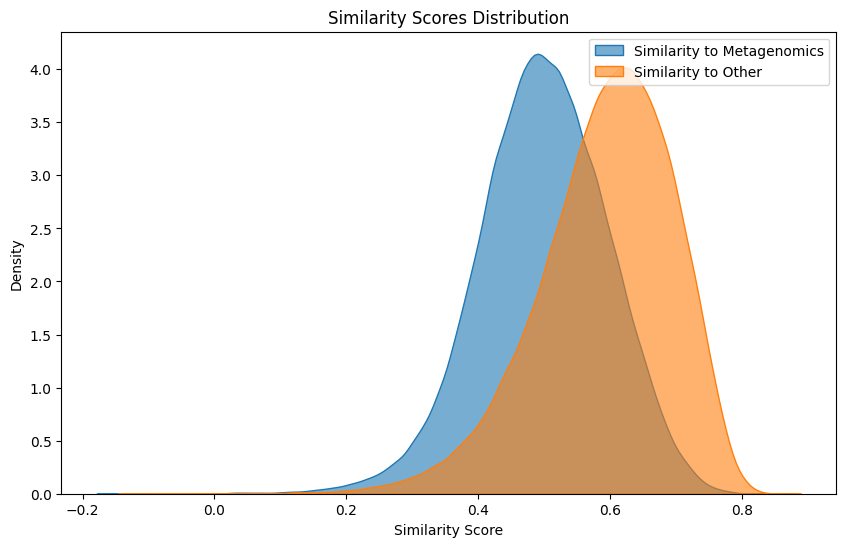

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot similarity scores
plt.figure(figsize=(10, 6))
sns.kdeplot(data['similarity_to_metagenomics'], label='Similarity to Metagenomics', fill=True, alpha=0.6)
sns.kdeplot(data['similarity_to_other'], label='Similarity to Other', fill=True, alpha=0.6)
plt.title('Similarity Scores Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.show()



Original Dataset Size: 219802
Filtered Dataset Size: 28193
class_label
other           27507
metagenomics      686
Name: count, dtype: int64


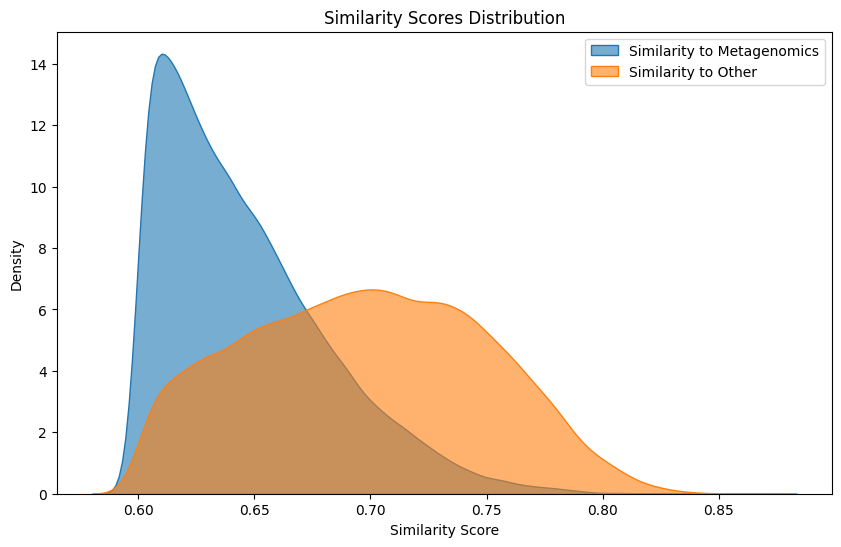

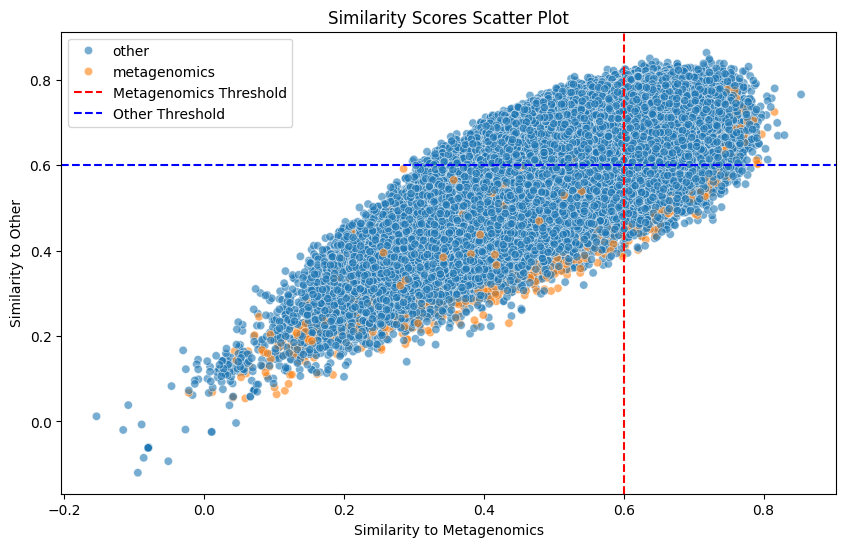

Classification Report:
              precision    recall  f1-score   support

metagenomics       0.09      0.66      0.17       141
       other       0.99      0.84      0.91      5498

    accuracy                           0.83      5639
   macro avg       0.54      0.75      0.54      5639
weighted avg       0.97      0.83      0.89      5639



In [53]:
# Define thresholds for filtering (adjust based on your requirements)
threshold_metagenomics = 0.6  # Very close to metagenomics
threshold_other = 0.6         # Very close to other

filtered_data = data[
    (data['similarity_to_metagenomics'] > threshold_metagenomics) &  # Close to metagenomics
    (data['similarity_to_other'] > threshold_other)                 # Far from other
]


# Save or view the filtered dataset
print(f"Original Dataset Size: {len(data)}")
print(f"Filtered Dataset Size: {len(filtered_data)}")
print(filtered_data['class_label'].value_counts())
filtered_data.head()



# Plot similarity scores
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['similarity_to_metagenomics'], label='Similarity to Metagenomics', fill=True, alpha=0.6)
sns.kdeplot(filtered_data['similarity_to_other'], label='Similarity to Other', fill=True, alpha=0.6)
plt.title('Similarity Scores Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.show()



# # Plot similarity scores
# plt.figure(figsize=(10, 6))
# sns.scatterplot(
#     x=data['similarity_to_metagenomics'],
#     y=data['similarity_to_other'],
#     hue=data['class_label'],
#     alpha=0.6
# )
# plt.axvline(threshold_metagenomics, color='red', linestyle='--', label='Metagenomics Threshold')
# plt.axhline(threshold_other, color='blue', linestyle='--', label='Other Threshold')
# plt.xlabel('Similarity to Metagenomics')
# plt.ylabel('Similarity to Other')
# plt.title('Similarity Scores Scatter Plot')
# plt.legend()
# plt.show()



# Prepare features and labels
X = np.vstack(filtered_data['loaded_embeddings'].values)
y = filtered_data['class_label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Generate and print classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

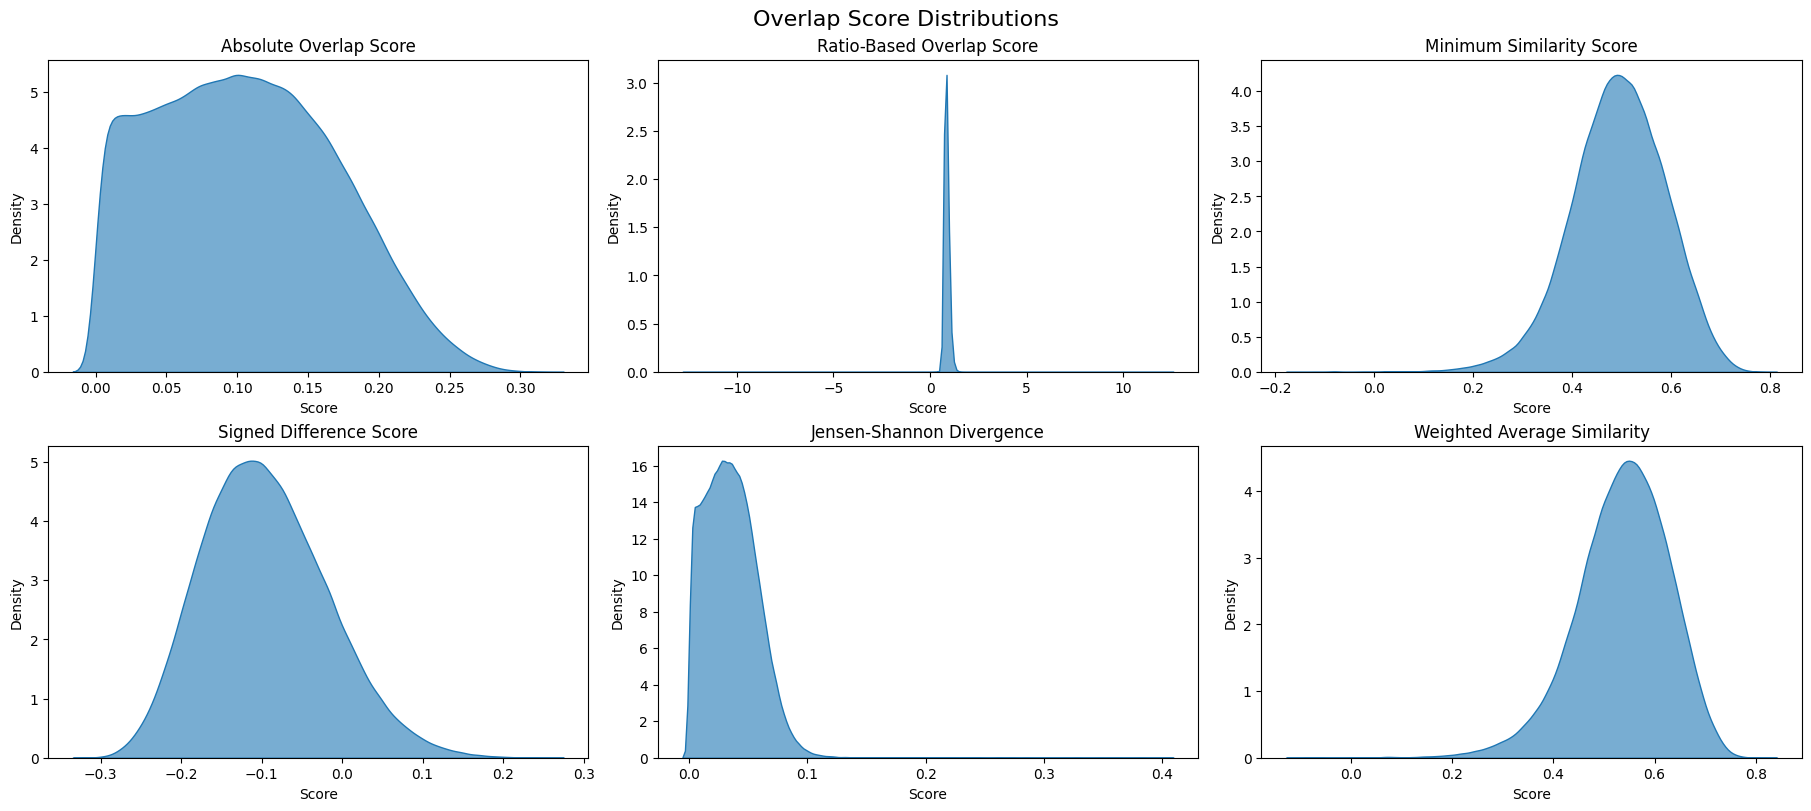

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define overlap score columns for plotting
overlap_scores = [
    'overlap_score', 
    'overlap_score_ratio', 
    'overlap_score_min', 
    'overlap_score_signed_diff', 
    'overlap_score_jsd', 
    'overlap_score_weighted', 
]

# Titles for each plot
titles = [
    'Absolute Overlap Score', 
    'Ratio-Based Overlap Score', 
    'Minimum Similarity Score', 
    'Signed Difference Score', 
    'Jensen-Shannon Divergence', 
    'Weighted Average Similarity', 
]

# Determine subplot grid dimensions (3 columns, dynamic rows)
n_cols = 3
n_rows = (len(overlap_scores) + n_cols - 1) // n_cols  # Round up

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 4), constrained_layout=True)

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot each overlap score in a separate subplot
for ax, score, title in zip(axes, overlap_scores, titles):
    if score == 'overlap_score_threshold':  # For threshold-based overlap, use histogram
        sns.histplot(data[score], ax=ax, kde=False, alpha=0.6, color='green')
    else:
        sns.kdeplot(data[score], ax=ax, fill=True, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

# Remove unused subplots if any
for ax in axes[len(overlap_scores):]:
    fig.delaxes(ax)

# Display the subplots
plt.suptitle('Overlap Score Distributions', fontsize=16)
plt.show()



Evaluating method: overlap_score


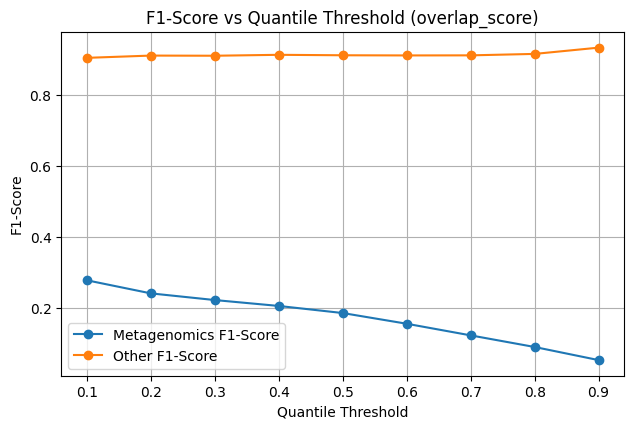

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# List of overlap score methods
overlap_methods = [
    'overlap_score',
#     'overlap_score_ratio',
#     'overlap_score_min',
#     'overlap_score_signed_diff',
#     'overlap_score_jsd',
#     'overlap_score_weighted',
]

# Initialize label encoder
label_encoder = LabelEncoder()

# Initialize results for plotting
results = {method: {'metagenomics': [], 'other': []} for method in overlap_methods}
quantiles = np.linspace(0.1, 0.9, 9)  # Quantiles for thresholds

# Iterate over each overlap method
for method in overlap_methods:
    print(f"\nEvaluating method: {method}")
    for quantile in tqdm(quantiles):
        # Calculate dynamic threshold for the method
        threshold = data[method].quantile(quantile)

        # Split data into non-overlapping and overlapping
        non_overlapping_data = data[data[method] > threshold]
        overlapping_data = data[data[method] <= threshold]

        # Prepare non-overlapping data
        X_non_overlap = np.vstack(non_overlapping_data['loaded_embeddings'].values)
        y_non_overlap = non_overlapping_data['class_label']

        # Encode labels
        y_encoded = label_encoder.fit_transform(y_non_overlap)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X_non_overlap, y_encoded, test_size=0.2, random_state=42)

        # Train Logistic Regression
        clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        clf.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

        # Store F1-scores
        results[method]['metagenomics'].append(report['metagenomics']['f1-score'])
        results[method]['other'].append(report['other']['f1-score'])

# Plot F1-scores for each method
plt.figure(figsize=(18, 12))
for i, method in enumerate(overlap_methods):
    plt.subplot(3, 3, i + 1)
    plt.plot(quantiles, results[method]['metagenomics'], label='Metagenomics F1-Score', marker='o')
    plt.plot(quantiles, results[method]['other'], label='Other F1-Score', marker='o')
    plt.title(f'F1-Score vs Quantile Threshold ({method})')
    plt.xlabel('Quantile Threshold')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Placeholder: Define the best quantile and overlapping technique
best_quantile = 0.9  # Replace with the best quantile
best_method = 'overlap_score'  # Replace with the best overlap technique

# Determine the threshold using the best quantile and method
threshold = data[best_method].quantile(best_quantile)

# Split data into non-overlapping and overlapping sets
non_overlapping_data = data[data[best_method] > threshold]
overlapping_data = data[data[best_method] <= threshold]

# Check sizes of each dataset
print(f"Non-overlapping data size: {non_overlapping_data.shape[0]}")
print(f"Overlapping data size: {overlapping_data.shape[0]}")

# TF-IDF preparation for non-overlapping data
X_tfidf_non_overlap_raw = non_overlapping_data['abstract']
y_non_overlap_raw = non_overlapping_data['class_label']

tfidf = TfidfVectorizer(
    max_features=1000,  # Increase the feature count if needed
    ngram_range=(1, 3),  # Use unigrams, bigrams, and trigrams
    stop_words='english',  # Exclude common stop words
    sublinear_tf=True,  # Apply sublinear term frequency scaling
)

# Transform non-overlapping abstracts
tfidf_non_overlap_matrix = tfidf.fit_transform(X_tfidf_non_overlap_raw)

# Combine TF-IDF features and embeddings for non-overlapping data
X_non_overlap = np.hstack([
    tfidf_non_overlap_matrix.toarray(),
    np.vstack(non_overlapping_data['loaded_embeddings'].values)
])
y_non_overlap = y_non_overlap_raw

# Encode labels for non-overlapping
label_encoder = LabelEncoder()
y_non_overlap_encoded = label_encoder.fit_transform(y_non_overlap)

# Split non-overlapping data
X_train_non_overlap, X_test_non_overlap, y_train_non_overlap, y_test_non_overlap = train_test_split(
    X_non_overlap, y_non_overlap_encoded, test_size=0.2, random_state=42
)

# Train Logistic Regression for non-overlapping data
clf_non_overlap = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf_non_overlap.fit(X_train_non_overlap, y_train_non_overlap)

# Predict and evaluate non-overlapping data
y_pred_non_overlap = clf_non_overlap.predict(X_test_non_overlap)
print("\nClassification Report for Non-Overlapping Data:")
print(classification_report(y_test_non_overlap, y_pred_non_overlap, target_names=label_encoder.classes_))

# TF-IDF preparation for overlapping data
X_tfidf_overlap_raw = overlapping_data['abstract']
y_overlap_raw = overlapping_data['class_label']

# Transform overlapping abstracts
tfidf_overlap_matrix = tfidf.transform(X_tfidf_overlap_raw)

# Combine TF-IDF features and embeddings for overlapping data
X_overlap = np.hstack([
    tfidf_overlap_matrix.toarray(),
    np.vstack(overlapping_data['loaded_embeddings'].values)
])
y_overlap = y_overlap_raw

# Encode labels for overlapping
y_overlap_encoded = label_encoder.fit_transform(y_overlap)

# Split overlapping data
X_train_overlap, X_test_overlap, y_train_overlap, y_test_overlap = train_test_split(
    X_overlap, y_overlap_encoded, test_size=0.2, random_state=42
)

# Train Logistic Regression for overlapping data
clf_overlap = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf_overlap.fit(X_train_overlap, y_train_overlap)

# Predict and evaluate overlapping data
y_pred_overlap = clf_overlap.predict(X_test_overlap)
print("\nClassification Report for Overlapping Data:")
print(classification_report(y_test_overlap, y_pred_overlap, target_names=label_encoder.classes_))


Non-overlapping data size: 21981
Overlapping data size: 197821

Classification Report for Non-Overlapping Data:
              precision    recall  f1-score   support

metagenomics       0.06      0.34      0.10        38
       other       0.99      0.95      0.97      4359

    accuracy                           0.95      4397
   macro avg       0.53      0.65      0.54      4397
weighted avg       0.99      0.95      0.96      4397



KeyError: 'embeddings'

In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
import numpy as np

# Combine non-overlapping and overlapping datasets for stacking
X_combined = np.vstack([X_non_overlap, X_overlap])
y_combined = np.hstack([y_non_overlap_encoded, y_overlap_encoded])

# Check consistency
assert X_combined.shape[0] == len(y_combined), "Mismatch between combined X and y!"

# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('non_overlap', clf_non_overlap), ('overlap', clf_overlap)],
    voting='soft'  # Use probabilities for voting
)

# Fit the Voting Classifier on the combined data
voting_clf.fit(X_combined, y_combined)

# Evaluate the Voting Classifier
X_test_combined = np.vstack([X_test_non_overlap, X_test_overlap])
y_test_combined = np.hstack([y_test_non_overlap, y_test_overlap])

y_pred_combined = voting_clf.predict(X_test_combined)

print("\nClassification Report for Combined Voting Classifier:")
print(classification_report(y_test_combined, y_pred_combined, target_names=label_encoder.classes_))



Classification Report for Combined Voting Classifier:
              precision    recall  f1-score   support

metagenomics       0.20      0.86      0.32      1886
       other       0.99      0.84      0.91     42076

    accuracy                           0.84     43962
   macro avg       0.59      0.85      0.62     43962
weighted avg       0.96      0.84      0.89     43962



In [20]:
# voting_clf = VotingClassifier(
#     estimators=[('non_overlap', clf_non_overlap), ('overlap', clf_overlap)],
#     voting='soft',
#     weights=[2, 1]  # Example: Give more weight to the non-overlapping classifier
# )

# # Fit the Voting Classifier on the combined data
# voting_clf.fit(X_combined, y_combined)

# # Evaluate the Voting Classifier
# X_test_combined = np.vstack([X_test_non_overlap, X_test_overlap])
# y_test_combined = np.hstack([y_test_non_overlap, y_test_overlap])

# y_pred_combined = voting_clf.predict(X_test_combined)

# print("\nClassification Report for Combined Voting Classifier:")
# print(classification_report(y_test_combined, y_pred_combined, target_names=label_encoder.classes_))


In [21]:
from transformers import AutoTokenizer, AutoModel

# Reload the model and tokenizer
model_name = "kaiserrr/Bilingual-BioSimCSE-BioLinkBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_similarity = AutoModel.from_pretrained(model_name)

/nfs/production/literature/santosh_tirunagari/transformers_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
import os
import pickle

# Define base directory for saving models
base_path = "/nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training"

# Create subdirectories for each type of model/component
os.makedirs(f"{base_path}/classifier", exist_ok=True)
os.makedirs(f"{base_path}/tfidf_vectorizer", exist_ok=True)
os.makedirs(f"{base_path}/label_encoder", exist_ok=True)
os.makedirs(f"{base_path}/huggingface", exist_ok=True)

# Save classifier
with open(f"{base_path}/classifier/clf_non_overlap.pkl", 'wb') as f:
    pickle.dump(clf_non_overlap, f)

# Save TF-IDF vectorizer
with open(f"{base_path}/tfidf_vectorizer/tfidf_vectorizer.pkl", 'wb') as f:
    pickle.dump(tfidf, f)

# Save label encoder
with open(f"{base_path}/label_encoder/label_encoder.pkl", 'wb') as f:
    pickle.dump(label_encoder, f)

# Save Hugging Face tokenizer and model
tokenizer_path = f"{base_path}/huggingface/kaiserrr_Bilingual-BioSimCSE-BioLinkBERT-base_tokenizer"
model_path = f"{base_path}/huggingface/kaiserrr_Bilingual-BioSimCSE-BioLinkBERT-base_model"
tokenizer.save_pretrained(tokenizer_path)
model_similarity.save_pretrained(model_path)

print(f"All components have been saved successfully to {base_path}")


All components have been saved successfully to /nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training


In [23]:
import pickle
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch

# Define base path where models are saved
base_path = "/nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training"

# Load the classifier
with open(f"{base_path}/classifier/clf_non_overlap.pkl", 'rb') as f:
    clf_non_overlap = pickle.load(f)

# Load the TF-IDF vectorizer
with open(f"{base_path}/tfidf_vectorizer/tfidf_vectorizer.pkl", 'rb') as f:
    tfidf = pickle.load(f)

# Load the label encoder
with open(f"{base_path}/label_encoder/label_encoder.pkl", 'rb') as f:
    label_encoder = pickle.load(f)

# Load the Hugging Face tokenizer and model
model_name = "kaiserrr_Bilingual-BioSimCSE-BioLinkBERT-base"
tokenizer_similarity = AutoTokenizer.from_pretrained(f"{base_path}/huggingface/{model_name}_tokenizer")
model_similarity = AutoModel.from_pretrained(f"{base_path}/huggingface/{model_name}_model").to('cpu')  # Move to CPU

# Define mean pooling function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Define classify_abstract function
def classify_abstract(abstract):
    """
    Classifies a single abstract using the loaded models.

    Parameters:
        abstract (str): The abstract to classify.

    Returns:
        dict: A dictionary containing the predicted class label and probabilities.
    """
    # TF-IDF transformation
    tfidf_features = tfidf.transform([abstract]).toarray()

    # Hugging Face embedding
    encoded_input = tokenizer_similarity(abstract, padding=True, truncation=True, return_tensors='pt').to('cpu')
    with torch.no_grad():
        model_output = model_similarity(**encoded_input)
    embedding_features = mean_pooling(model_output, encoded_input['attention_mask']).cpu().numpy()

    # Combine TF-IDF and embedding features
    combined_features = np.hstack([tfidf_features, embedding_features])

    # Predict class probabilities
    probabilities = clf_non_overlap.predict_proba(combined_features)[0]

    # Get predicted class
    predicted_class = label_encoder.inverse_transform([np.argmax(probabilities)])[0]

    return {
        "predicted_class": predicted_class,
        "probabilities": probabilities
    }



In [24]:
# Extract abstracts and true labels from non-overlapping dataset
non_overlapping_abstracts = non_overlapping_data['abstract'].tolist()
true_labels = non_overlapping_data['class_label'].tolist()

# Predict labels using the classify_abstract function
predicted_labels = [
    classify_abstract(abstract)['predicted_class'] for abstract in tqdm(non_overlapping_abstracts, desc="Classifying Non-Overlapping Data")
]

# Print the classification report
print("\nClassification Report for Non-Overlapping Data:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))


Classifying Non-Overlapping Data: 100%|█████████████████████████████| 21981/21981 [25:23<00:00, 14.43it/s]



Classification Report for Non-Overlapping Data:
              precision    recall  f1-score   support

metagenomics       0.57      0.97      0.72       614
       other       1.00      0.98      0.99     21367

    accuracy                           0.98     21981
   macro avg       0.78      0.98      0.85     21981
weighted avg       0.99      0.98      0.98     21981



In [34]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from tqdm import tqdm
import numpy as np


# Batch processing for classification
def classify_abstracts_in_batches(abstracts, batch_size=32, use_manual=True):
    """
    Classifies a list of abstracts using the custom model with batch processing.

    Parameters:
        abstracts (list): List of abstract strings to classify.
        batch_size (int): Batch size for processing.
        use_manual (bool): Whether to manually compute logits for verification.

    Returns:
        tuple: A tuple containing:
            - list: Predicted labels for all abstracts.
            - list: Predicted probabilities for all abstracts.
    """
    predicted_labels = []
    predicted_probabilities = []

    for i in tqdm(range(0, len(abstracts), batch_size), desc="Processing Batches"):
        # Get the current batch
        batch = abstracts[i:i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Predict using the model
        model.eval()
        with torch.no_grad():
            logits_builtin, embeddings = model(input_ids=input_ids, attention_mask=attention_mask)

            # Manually compute logits if required
            if use_manual:
                logits_manual = torch.matmul(embeddings, classifier_weights.T) + classifier_biases
                assert torch.allclose(logits_builtin, logits_manual, atol=1e-6), "Results differ between manual and built-in!"
                logits = logits_manual
            else:
                logits = logits_builtin

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()

        # Get predicted classes for the batch
        predicted_classes = np.argmax(probabilities, axis=1)
        predicted_labels.extend(label_encoder.inverse_transform(predicted_classes))
        predicted_probabilities.extend(probabilities)

    return predicted_labels, predicted_probabilities


# Define the custom ClassificationModel class
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use pooler_output or the [CLS] token from the last_hidden_state
        embeddings = (
            outputs.pooler_output
            if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None
            else outputs.last_hidden_state[:, 0, :]
        )
        logits = self.classifier(embeddings)
        return logits, embeddings

# Paths to model and label encoder
model_path = "/nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training/MCBC_model/best_model/best_contrastive_binary_model_absurd-sweep-98.pth"
encoder_path = "/nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training/MCBC_model/best_model/best_label_encoder_absurd-sweep-98.pkl"
pretrained_model_name = "bioformers/bioformer-8L"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

# Ensure model is on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure classifier weights and biases are on the correct device
classifier_weights = model.classifier.weight.to(device)
classifier_biases = model.classifier.bias.to(device)
# Load the encoder and define the custom model
encoder = AutoModel.from_pretrained(pretrained_model_name)
model = ClassificationModel(encoder=encoder, num_classes=2)  # Update num_classes if needed
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)  # Map model to the correct device
model.to(device)  # Ensure model is on the selected device

# Load the label encoder
with open(encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

print("Model and all components are successfully loaded and ready for inference.")


/nfs/production/literature/santosh_tirunagari/transformers_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model and all components are successfully loaded and ready for inference.


In [29]:
# Prepare overlapping and non-overlapping datasets
non_overlapping_abstracts = non_overlapping_data['abstract'].tolist()
overlapping_abstracts = overlapping_data['abstract'].tolist()

# Classify non-overlapping abstracts
print("Classifying Non-Overlapping Abstracts...")
non_overlapping_labels = classify_abstracts_in_batches(non_overlapping_abstracts, batch_size=32, use_manual=True)

# Classify overlapping abstracts
print("Classifying Overlapping Abstracts...")
overlapping_labels = classify_abstracts_in_batches(overlapping_abstracts, batch_size=32, use_manual=True)

# Add predictions to the datasets for evaluation
non_overlapping_data['predicted_label'] = non_overlapping_labels
overlapping_data['predicted_label'] = overlapping_labels




Classifying Non-Overlapping Abstracts...


Processing Batches: 100%|███████████████████████████████████████████████| 687/687 [01:02<00:00, 11.03it/s]


Classifying Overlapping Abstracts...


Processing Batches: 100%|█████████████████████████████████████████████| 6182/6182 [09:55<00:00, 10.38it/s]
/tmp/ipykernel_3424216/3525525374.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_overlapping_data['predicted_label'] = non_overlapping_labels
/tmp/ipykernel_3424216/3525525374.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlapping_data['predicted_label'] = overlapping_labels


In [30]:
# Evaluate and print classification reports
from sklearn.metrics import classification_report

print("\nClassification Report for Non-Overlapping Data:")
print(classification_report(non_overlapping_data['class_label'], non_overlapping_data['predicted_label']))

print("\nClassification Report for Overlapping Data:")
print(classification_report(overlapping_data['class_label'], overlapping_data['predicted_label']))


Classification Report for Non-Overlapping Data:
              precision    recall  f1-score   support

metagenomics       0.48      0.92      0.63       614
       other       1.00      0.97      0.98     21367

    accuracy                           0.97     21981
   macro avg       0.74      0.94      0.81     21981
weighted avg       0.98      0.97      0.97     21981


Classification Report for Overlapping Data:
              precision    recall  f1-score   support

metagenomics       0.19      0.91      0.32      8886
       other       0.99      0.82      0.90    188935

    accuracy                           0.82    197821
   macro avg       0.59      0.86      0.61    197821
weighted avg       0.96      0.82      0.87    197821



In [10]:
abstract_1 = '''
Viruses are the most common biological entities in the marine environment. There has not been a global survey of these viruses, and consequently, it is not known what types of viruses are in Earth's oceans or how they are distributed. Metagenomic analyses of 184 viral assemblages collected over a decade and representing 68 sites in four major oceanic regions showed that most of the viral sequences were not similar to those in the current databases. There was a distinct "marine-ness" quality to the viral assemblages. Global diversity was very high, presumably several hundred thousand of species, and regional richness varied on a North-South latitudinal gradient. The marine regions had different assemblages of viruses. Cyanophages and a newly discovered clade of single-stranded DNA phages dominated the Sargasso Sea sample, whereas prophage-like sequences were most common in the Arctic. However most viral species were found to be widespread. With a majority of shared species between oceanic regions, most of the differences between viral assemblages seemed to be explained by variation in the occurrence of the most common viral species and not by exclusion of different viral genomes. These results support the idea that viruses are widely dispersed and that local environmental conditions enrich for certain viral types through selective pressure.
'''


print(classify_abstract(abstract_1))
print(classify_abstracts_in_batches([abstract_1]))

NameError: name 'classify_abstract' is not defined